In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
# Data directory
DATADIR = 'UCI HAR Dataset'

In [44]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [45]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

In [46]:
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [47]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [48]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [49]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [50]:
X_train, X_test, Y_train, Y_test = load_data()

In [51]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [52]:
X_train.shape

(7352, 128, 9)

In [53]:
def TCN(input_layer, filters):
    x = input_layer
    for dilation in [1, 2, 4]:
        x = Conv1D(filters, kernel_size=3, padding='causal', dilation_rate=dilation)(x)
        x = Activation('relu')(x)
    return x


In [54]:
class SelfAttention(Layer):
    def __init__(self, units, dropout_rate=0.2, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.query_dense = Dense(self.units)
        self.key_dense = Dense(self.units)
        self.value_dense = Dense(self.units)
        self.dropout = Dropout(self.dropout_rate)
        self.layernorm = LayerNormalization()

    def call(self, inputs):
        x = self.layernorm(inputs)
        query = self.query_dense(x)
        key = self.key_dense(x)
        value = self.value_dense(x)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores /= tf.math.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_weights = self.dropout(attention_weights)

        return tf.matmul(attention_weights, value)

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units, "dropout_rate": self.dropout_rate})
        return config

In [55]:
from tensorflow.keras.layers import LayerNormalization

input_layer = Input(shape=(timesteps, input_dim))
x = TCN(input_layer, filters=64)
x = LayerNormalization()(x)
x = SelfAttention(units=64)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 activation_9 (Activation)   (None, 128, 64)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 128, 64)           12352     
                                                                 
 activation_10 (Activation)  (None, 128, 64)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 128, 64)           12352     
                                                                 
 activation_11 (Activation)  (None, 128, 64)           0   

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [57]:
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test)
)

Epoch 1/30
460/460 [==============================] - 21s 37ms/step - loss: 0.3404 - accuracy: 0.8743 - val_loss: 0.4122 - val_accuracy: 0.8744
Epoch 2/30
460/460 [==============================] - 17s 36ms/step - loss: 0.1553 - accuracy: 0.9406 - val_loss: 0.3095 - val_accuracy: 0.9138
Epoch 3/30
460/460 [==============================] - 15s 33ms/step - loss: 0.1299 - accuracy: 0.9497 - val_loss: 0.3829 - val_accuracy: 0.8951
Epoch 4/30
460/460 [==============================] - 16s 35ms/step - loss: 0.1202 - accuracy: 0.9509 - val_loss: 0.4600 - val_accuracy: 0.9101
Epoch 5/30
460/460 [==============================] - 19s 41ms/step - loss: 0.1114 - accuracy: 0.9572 - val_loss: 0.3678 - val_accuracy: 0.9030
Epoch 6/30
460/460 [==============================] - 15s 34ms/step - loss: 0.1069 - accuracy: 0.9576 - val_loss: 0.2557 - val_accuracy: 0.9386
Epoch 7/30
460/460 [==============================] - 15s 33ms/step - loss: 0.0991 - accuracy: 0.9573 - val_loss: 0.3389 - val_accuracy:

93/93 [==============================] - 2s 17ms/step - loss: 0.5637 - accuracy: 0.9040

Test Loss: 0.5636909008026123
Test Accuracy: 0.9039701223373413
93/93 [==============================] - 2s 14ms/step

Accuracy:  0.9040
Precision: 0.9062
Recall:    0.9053
F1 Score:  0.9047

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.97      0.93      0.95       496
  WALKING_UPSTAIRS       0.99      0.88      0.93       471
WALKING_DOWNSTAIRS       0.89      0.99      0.94       420
           SITTING       0.79      0.79      0.79       491
          STANDING       0.82      0.84      0.83       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.90      2947
         macro avg       0.91      0.91      0.90      2947
      weighted avg       0.91      0.90      0.90      2947



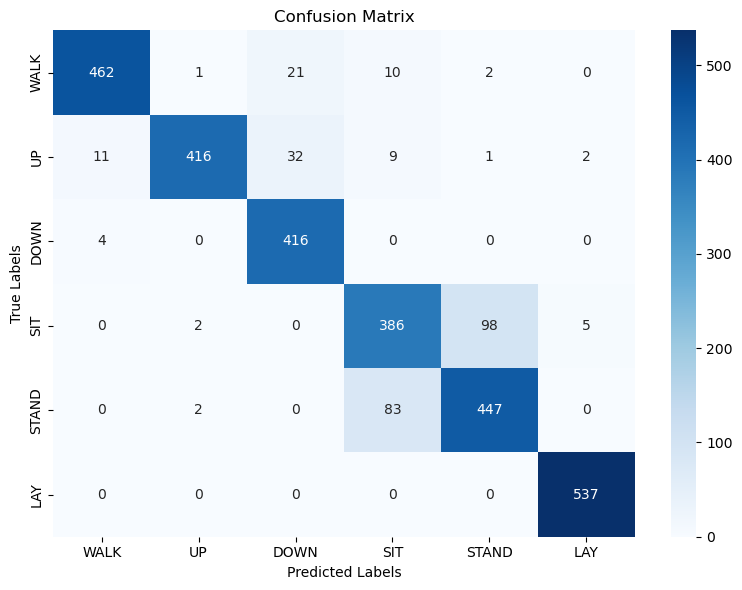

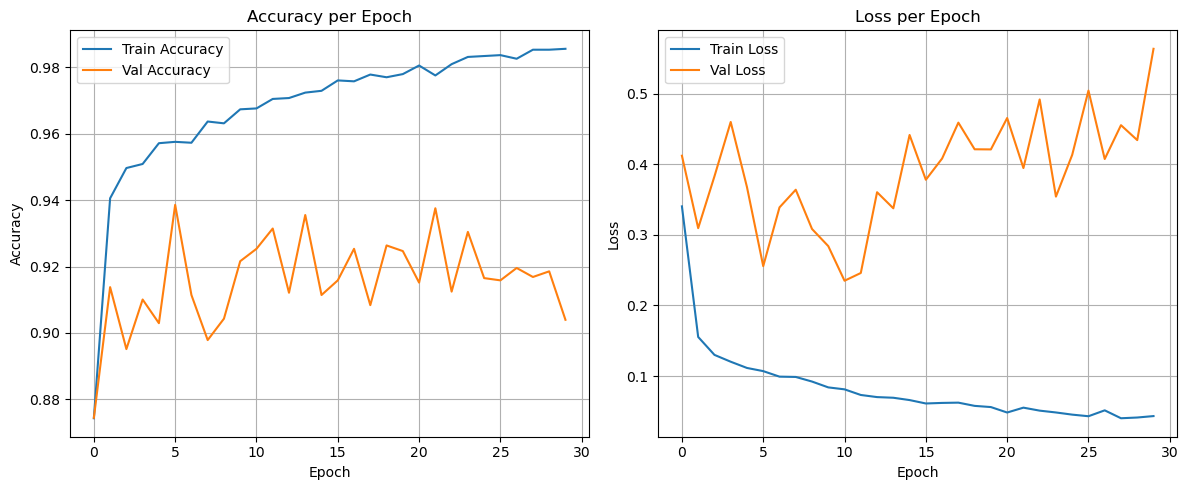

In [58]:
# --- METRIK EVALUASI ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluate model
score = model.evaluate(X_test, Y_test)
print(f"\nTest Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
    "SITTING", "STANDING", "LAYING"
]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["WALK", "UP", "DOWN", "SIT", "STAND", "LAY"],
            yticklabels=["WALK", "UP", "DOWN", "SIT", "STAND", "LAY"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# --- VISUALISASI TRAINING ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
